In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import shap

Fazendo a junção de duas tabelas para ter mais informações para a probabilide de churn

In [20]:
conexao = sqlite3.connect(r'C:\Users\heloi\OneDrive\Desktop\Projeto - Inlytics\Dataset\db_cliente_sqlite\empresa_cliente_db.db')

df_customer_user = pd.read_sql('SELECT * FROM customer_user', conexao)
df_customer_sales = pd.read_sql('SELECT * FROM customer_sales', conexao)
df_rfm = pd.read_csv(r'C:\Users\heloi\OneDrive\Desktop\Projeto - Inlytics\dados_temporarios_rfm_csv\rfm_dados_gerais.csv')
conexao.close()

df_customer_sales['InvoiceDate'] = pd.to_datetime(df_customer_sales['InvoiceDate'])
df_customer_sales['DateStartBase'] = df_customer_sales['InvoiceDate'].dt.strftime('%Y-%m-%d')

df_customer_min_invoice = df_customer_sales.groupby('CustomerID')['DateStartBase'].agg('min').reset_index()

df_user_rfm = pd.merge(df_customer_user, df_rfm, on='CustomerID', how='left')
df_all_data = pd.merge(df_user_rfm, df_customer_min_invoice, on='CustomerID', how='left')
df_all_data = df_all_data.drop(columns=['Tenure', 'Segment'])

df_all_data.head(10)

,CustomerID,Churn,PreferredLoginDevice,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,Complain,CouponUsed,NomeCustomer,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,DateStartBase
0,17850.0,1,Mobile Phone,Debit Card,Female,3.0,2,Single,1,1.0,Srta. Amanda Sousa,372.0,34.0,5391.21,1.0,5.0,5.0,2010-12-01
1,13047.0,1,Phone,UPI,Male,4.0,3,Single,1,0.0,Joaquim Câmara,32.0,10.0,3237.54,4.0,5.0,5.0,2010-12-01
2,12583.0,1,Phone,Debit Card,Male,4.0,3,Single,1,0.0,Cauã Rocha,3.0,15.0,7281.38,5.0,5.0,5.0,2010-12-01
3,13748.0,1,Phone,Debit Card,Male,4.0,5,Single,0,0.0,Sr. Otávio Andrade,96.0,5.0,948.25,2.0,4.0,4.0,2010-12-01
4,15100.0,1,Phone,CC,Male,3.0,5,Single,0,1.0,Caleb Cunha,334.0,3.0,876.00,1.0,3.0,3.0,2010-12-01
5,15291.0,1,Computer,Debit Card,Female,5.0,5,Single,1,4.0,Sofia Pereira,26.0,15.0,4668.30,4.0,5.0,5.0,2010-12-01
6,14688.0,1,Phone,Cash on Delivery,Male,3.0,2,Divorced,0,0.0,Gael Henrique Silva,8.0,21.0,5630.87,5.0,5.0,5.0,2010-12-01
7,17809.0,1,Phone,CC,Male,3.0,2,Divorced,1,2.0,Dr. Henry Machado,16.0,12.0,5411.91,4.0,5.0,5.0,2010-12-01
8,15311.0,1,Phone,Debit Card,Male,5.0,3,None,0,1.0,João Lucas Abreu,1.0,91.0,60767.90,5.0,5.0,5.0,2010-12-01
9,14527.0,1,Mobile Phone,Cash on Delivery,Female,3.0,3,Divorced,0,9.0,Mariana Fernandes,3.0,55.0,8508.82,5.0,5.0,5.0,2010-12-05


In [21]:
df_all_data.shape

(4372, 18)

In [22]:
data_referencia = pd.to_datetime('2011-12-09')

df_all_data['DateStartBase'] = pd.to_datetime(df_all_data['DateStartBase'])
df_all_data['DateStart_Days'] = (data_referencia - df_all_data['DateStartBase']).dt.days

dados_sem_null = df_all_data['DateStart_Days'].dropna()
dados_sem_null.shape

(4338,)

In [23]:
df_all_data.columns

Index(['CustomerID', 'Churn', 'PreferredLoginDevice', 'PreferredPaymentMode',
       'Gender', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'MaritalStatus', 'Complain', 'CouponUsed', 'NomeCustomer', 'Recency',
       'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score',
       'DateStartBase', 'DateStart_Days'],
      dtype='object')

Verificação do desbalanceamento da Target - Churn

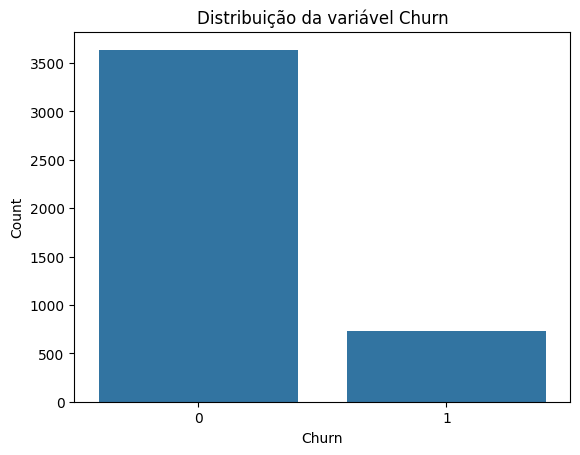

In [24]:
target_counts = df_all_data['Churn'].value_counts().reset_index()
target_counts.columns = ['Churn', 'Count']

sns.barplot(x='Churn', y='Count', data=target_counts)
plt.title('Distribuição da variável Churn')
plt.show()

Visualizar as correlações

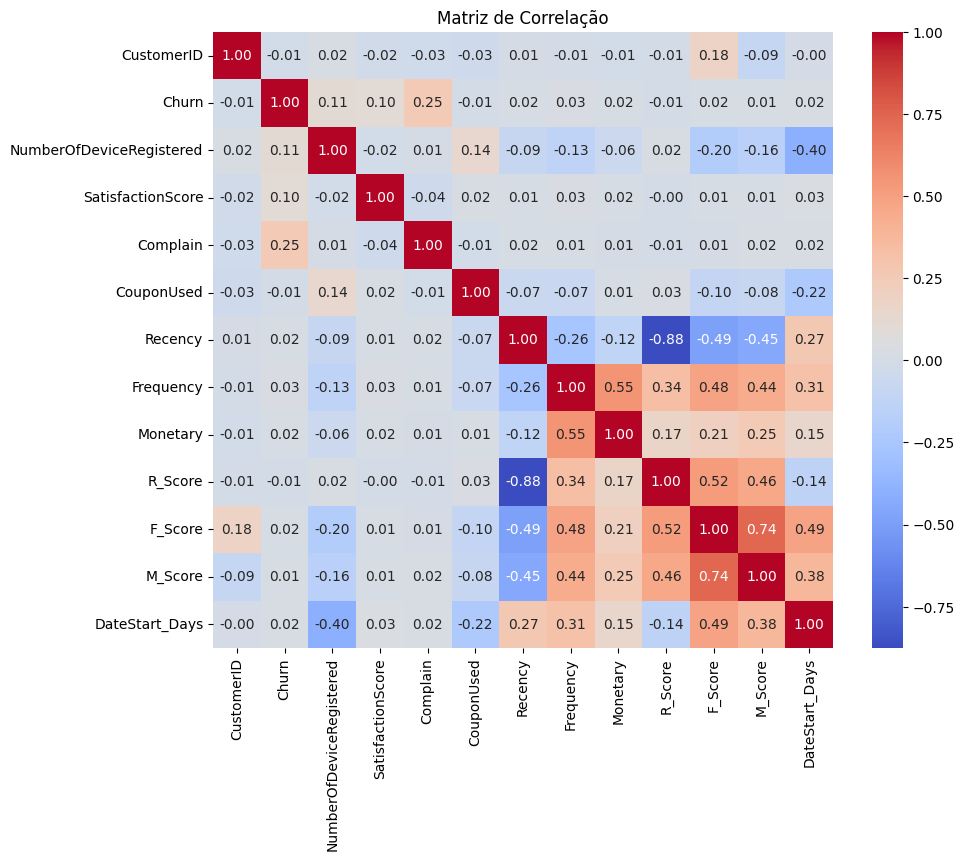

In [25]:
# Opção 1: Filtrando colunas numéricas
correlacao = df_all_data.select_dtypes(include=['number']).corr()

# Ou Opção 2: Usando o parâmetro numeric_only
correlacao = df_all_data.corr(numeric_only=True)

# Visualizando a matriz de correlação como um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()


Com base nas informações anteriores irei seguir os seguintes passos para utilizar a Random Forest:

- Tratamento de valores ausentes
- Codificação da variável categóricas
- Remoção de colunas irrelevantes ou duplicadas (RFE)
- Balanceamento de classes (SMOTE)

In [26]:
df = df_all_data.copy()

df.drop(columns=['CustomerID', 'NomeCustomer', 'DateStartBase'], inplace=True)

categorical_features = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'MaritalStatus']
numeric_features = [col for col in df.columns if col not in categorical_features + ['Churn']]

from sklearn.model_selection import train_test_split

x = df.drop(columns=['Churn'])  
y = df['Churn']

In [27]:
df.columns

Index(['Churn', 'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'MaritalStatus',
       'Complain', 'CouponUsed', 'Recency', 'Frequency', 'Monetary', 'R_Score',
       'F_Score', 'M_Score', 'DateStart_Days'],
      dtype='object')

In [28]:
x.head()

,PreferredLoginDevice,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,Complain,CouponUsed,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,DateStart_Days
0,Mobile Phone,Debit Card,Female,3.0,2,Single,1,1.0,372.0,34.0,5391.21,1.0,5.0,5.0,373.0
1,Phone,UPI,Male,4.0,3,Single,1,0.0,32.0,10.0,3237.54,4.0,5.0,5.0,373.0
2,Phone,Debit Card,Male,4.0,3,Single,1,0.0,3.0,15.0,7281.38,5.0,5.0,5.0,373.0
3,Phone,Debit Card,Male,4.0,5,Single,0,0.0,96.0,5.0,948.25,2.0,4.0,4.0,373.0
4,Phone,CC,Male,3.0,5,Single,0,1.0,334.0,3.0,876.00,1.0,3.0,3.0,373.0


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [30]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Pipeline para Decision Tree
pipeline_dt = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),
    ('classifier', DecisionTreeClassifier(class_weight='balanced'))
])

# # Pipeline para Random Forest
pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])

# # Pipeline para Logistic Regression
pipeline_logit = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),
    ('standardscaler', StandardScaler()),
    # ('pca', PCA(n_components=0.95)),
    ('classifier', LogisticRegression(max_iter=1500, class_weight='balanced'))
])


In [31]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_predict

pipelines = {
    "Decision Tree": pipeline_dt,
    "Random Forest": pipeline_rf,
    "Logistic Regression": pipeline_logit
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



scoring = {
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'recall': 'recall',
    'precision': 'precision'
}

for model_name, pipeline in pipelines.items():
    # 1. Avaliação com cross_validate (para métricas)
    cv_results = cross_validate(pipeline, x, y, cv=skf, scoring=scoring)
    print(f"\n{model_name}:")
    for metric in scoring:
        print(f"  {metric}: {cv_results[f'test_{metric}'].mean():.4f}")
    
    # 2. Obter previsões de todas as dobras (para matriz de confusão)
    y_pred = cross_val_predict(pipeline, x, y, cv=skf)
    conf_matrix = confusion_matrix(y, y_pred)
    print("\nMatriz de Confusão:")
    print(conf_matrix)
    print("-"*40)




Decision Tree:
  f1: 0.3547
  roc_auc: 0.6132
  recall: 0.3730
  precision: 0.3394

Matriz de Confusão:
[[3081  556]
 [ 453  282]]
----------------------------------------

Random Forest:
  f1: 0.3621
  roc_auc: 0.7563
  recall: 0.2531
  precision: 0.6476

Matriz de Confusão:
[[3538   99]
 [ 557  178]]
----------------------------------------

Logistic Regression:
  f1: 0.4308
  roc_auc: 0.7556
  recall: 0.6599
  precision: 0.3201

Matriz de Confusão:
[[2599 1038]
 [ 248  487]]
----------------------------------------


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# 1. Divida os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Crie um pipeline com escalonamento e modelo
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# 3. Defina a grade de hiperparâmetros para busca
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.01, 0.05, 0.1, 1],
    'classifier__solver': ['saga'],
    'classifier__l1_ratio': [0, 0.1, 0.5, 1]
}


# 4. Configure o Stratified K-Fold para validação cruzada
strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 5. Configure o GridSearchCV usando StratifiedKFold
grid_search = GridSearchCV(
    estimator=pipeline_logit,
    param_grid=param_grid,
    scoring='recall',  # ou 'f1', 'roc_auc' conforme seu objetivo
    cv=strat_kfold,
    n_jobs=-1,
    verbose=1
)

# 6. Execute o ajuste dos hiperparâmetros
grid_search.fit(X_train, y_train)

# 7. Avalie os melhores hiperparâmetros e desempenho
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor recall na validação:", grid_search.best_score_)

# 8. Avalie no conjunto de teste
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Melhores parâmetros: {'classifier__C': 0.01, 'classifier__l1_ratio': 1, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Melhor recall na validação: 0.6853886616014028
              precision    recall  f1-score   support

           0       0.91      0.70      0.79       728
           1       0.30      0.65      0.41       147

    accuracy                           0.69       875
   macro avg       0.60      0.67      0.60       875
weighted avg       0.81      0.69      0.73       875

[[508 220]
 [ 52  95]]


Melhores parâmetros: {'classifier__C': 0.01, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Melhor recall na validação: 0.6853252209184413
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       728
           1       0.30      0.63      0.41       147

    accuracy                           0.69       875
   macro avg       0.60      0.67      0.60       875
weighted avg       0.80      0.69      0.73       875

[[510 218]
 [ 54  93]]


Melhores parâmetros: {'classifier__C': 0.01, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Melhor recall na validação: 0.6802115022454005
              precision    recall  f1-score   support

           0       0.91      0.69      0.79       728
           1       0.30      0.64      0.41       147

    accuracy                           0.68       875
   macro avg       0.60      0.67      0.60       875
weighted avg       0.80      0.68      0.72       875

[[505 223]
 [ 53  94]]

In [46]:
melhores_parametros = {
    'C': 0.01,
    'l1_ratio': 1,
    'penalty': 'elasticnet',
    'solver': 'saga',
    'max_iter': 1500,
    'class_weight': 'balanced'  # recomendado para churn
}

pipeline_logit_final = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),
    ('standardscaler', StandardScaler()),
    # ('pca', PCA(n_components=0.95)),
    ('classifier', LogisticRegression(**melhores_parametros))
])

pipeline_logit_final.fit(X_train, y_train)

y_pred = pipeline_logit_final.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", cm)

              precision    recall  f1-score   support

           0       0.90      0.70      0.79       728
           1       0.30      0.63      0.40       147

    accuracy                           0.69       875
   macro avg       0.60      0.66      0.60       875
weighted avg       0.80      0.69      0.72       875

Matriz de Confusão:
 [[507 221]
 [ 54  93]]


In [48]:
import joblib

joblib.dump(pipeline_logit_final, r'C:\Users\heloi\OneDrive\Desktop\Projeto - Inlytics\scr\model\modelo_churn_final.pkl')

['C:\\Users\\heloi\\OneDrive\\Desktop\\Projeto - Inlytics\\scr\\model\\modelo_churn_final.pkl']

In [52]:
customer_ids = df_all_data['CustomerID'].copy()
y_proba = pipeline_logit_final.predict_proba(df_all_data)[:, 1]

# Criar DataFrame com CustomerID e probabilidade de churn
df_resultado = pd.DataFrame({
    'CustomerID': customer_ids,
    'Probabilidade_Churn': y_proba
})

print(df_resultado.head())

   CustomerID  Probabilidade_Churn
0     17850.0             0.637772
1     13047.0             0.855739
2     12583.0             0.856598
3     13748.0             0.650958
4     15100.0             0.595514


Daqui para baixo é apenas para conferencia de informação

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Supondo que seu DataFrame se chama df_all_data
df = df_all_data.copy()

# Remover colunas irrelevantes para o modelo
df.drop(columns=['CustomerID', 'NomeCustomer', 'DateStartBase'], inplace=True)

# Definir variáveis categóricas e numéricas
categorical_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'MaritalStatus', 'Segment']
numeric_cols = [col for col in df.columns if col not in categorical_cols + ['Churn']]

X = df.drop('Churn', axis=1)
y = df['Churn']

# Pré-processamento separado para numéricas e categóricas
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [66]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Pipeline para pré-processar e aplicar RFE
rfc_estimator = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

pipeline_rfe = Pipeline([
    ('preprocessor', preprocessor),
    ('rfe', RFE(estimator=rfc_estimator, n_features_to_select=15))
])

pipeline_rfe.fit(X_train, y_train)

# Recuperar nomes das features após one-hot encoding
preprocessor_fit = pipeline_rfe.named_steps['preprocessor']
num_features = numeric_cols
cat_features = preprocessor_fit.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])

mask = pipeline_rfe.named_steps['rfe'].support_
selected_features = all_features[mask]
print("Features selecionadas pelo RFE:")
print(selected_features)


Features selecionadas pelo RFE:
['Tenure' 'NumberOfDeviceRegistered' 'SatisfactionScore' 'Complain'
 'CouponUsed' 'Recency' 'Frequency' 'Monetary' 'R_Score' 'F_Score'
 'M_Score' 'PreferredLoginDevice_Mobile Phone' 'Gender_Female'
 'MaritalStatus_Married' 'MaritalStatus_Single']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', RFE(estimator=rfc_estimator, n_features_to_select=15)),
        ('classifier', model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
    results[name] = scores.mean()
    print(f"{name} AUC médio: {scores.mean():.4f}")


Logistic Regression AUC médio: 0.7522
Random Forest AUC médio: 0.8506
Gradient Boosting AUC médio: 0.8662


In [68]:
from sklearn.model_selection import GridSearchCV

best_model = RandomForestClassifier(random_state=42, class_weight='balanced')

pipeline_final = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', RFE(estimator=rfc_estimator, n_features_to_select=15)),
    ('classifier', best_model)
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline_final, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)

# Avaliar no teste
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print("ROC AUC no teste:", roc_auc_score(y_test, y_proba))


Melhores hiperparâmetros: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1091
           1       0.67      0.52      0.58       221

    accuracy                           0.88      1312
   macro avg       0.79      0.73      0.76      1312
weighted avg       0.87      0.88      0.87      1312

ROC AUC no teste: 0.8871805931707802


In [ ]:
import shap

# Extrair modelo treinado e dados transformados
final_model = grid_search.best_estimator_.named_steps['classifier']
X_test_transformed = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_test_selected = X_test_transformed[:, mask]

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

shap.summary_plot(shap_values[1], features=X_test_selected, feature_names=selected_features)


NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.